# Numerai tournament: Example for using Keras with custom callback
In this notebook you will see an example of how to use a custom callback to print a summary of metrics after each epoch.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/chricke/Numerai-Keras/blob/master/Numerai-Keras.ipynb)

First import the needed libraries.

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
import tensorflow as tf

Just for information: print info on the installed Tensorflow version and if GPU is enabled.

In [2]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.2.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Next i will set some variables for the path to the data files, the name of the save file for the best model, how the predictions file should be named and the names of the data files.

In [3]:
data_path = './'
max_score_save_file = 'keras_max_score.h5'
predictions_file_name = 'predictions_keras.csv'
training_file = 'numerai_training_data.csv'
tournament_file = 'numerai_tournament_data.csv'

### Import the data

Now it is time to import the data - first the training data.

In [4]:
train_df = pd.read_csv(f'{data_path}/{training_file}')
train_df.head()

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,...,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target_kazutsugi
0,n000315175b67977,era1,train,0.00,0.50,0.25,0.00,0.5,0.25,0.25,...,1.00,1.00,0.75,0.50,0.75,0.50,1.00,0.50,0.75,0.75
1,n0014af834a96cdd,era1,train,0.00,0.00,0.00,0.25,0.5,0.00,0.00,...,1.00,1.00,0.00,0.00,0.75,0.25,0.00,0.25,1.00,0.25
2,n001c93979ac41d4,era1,train,0.25,0.50,0.25,0.25,1.0,0.75,0.75,...,0.25,0.50,0.00,0.00,0.50,1.00,0.00,0.25,0.75,0.00
3,n0034e4143f22a13,era1,train,1.00,0.00,0.00,0.50,0.5,0.25,0.25,...,1.00,1.00,0.75,0.75,1.00,1.00,0.75,1.00,1.00,0.00
4,n00679d1a636062f,era1,train,0.25,0.25,0.25,0.25,0.0,0.25,0.50,...,0.75,0.75,0.25,0.50,0.75,0.00,0.50,0.25,0.75,0.75


And now the tournament data. We will use this for two things:
- to do the predictions for the submission file at the end of this notebook
- to use the validation data in this file as the validation data in the model

In [5]:
tournament_df = pd.read_csv(f'{data_path}/{tournament_file}')
tournament_df.head()

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,...,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target_kazutsugi
0,n0003aa52cab36c2,era121,validation,0.25,0.75,0.50,0.50,0.0,0.75,0.5,...,0.75,0.75,1.00,0.75,0.50,0.5,1.0,0.00,0.00,0.00
1,n000920ed083903f,era121,validation,0.75,0.50,0.75,1.00,0.5,0.00,0.0,...,0.50,0.50,0.75,1.00,0.75,0.5,0.5,0.50,0.50,0.25
2,n0038e640522c4a6,era121,validation,1.00,0.00,0.00,1.00,1.0,1.00,1.0,...,0.00,0.00,0.50,0.25,0.00,0.0,0.5,0.50,0.00,1.00
3,n004ac94a87dc54b,era121,validation,0.75,1.00,1.00,0.50,0.0,0.00,0.0,...,0.00,0.00,0.00,0.25,0.00,0.0,0.0,0.25,0.25,0.75
4,n0052fe97ea0c05f,era121,validation,0.25,0.50,0.50,0.25,1.0,0.50,0.5,...,0.50,0.75,0.00,0.00,0.75,1.0,0.0,0.25,1.00,1.00


Next we will filter all the name features name from the columns in the training data.

In [6]:
features = [column for column in train_df if column.startswith("feature")]

Now create a DataFrame with the validation data - we do this by selecting the data from the tournament file for which a target is available.

In [7]:
val_df = tournament_df[tournament_df['target_kazutsugi'].notnull()]

### Define the metrics
Now the data is loaded we should define the metrics we will use to evaluate the model with our custom callback.
This is taken from here: https://forum.numer.ai/t/more-metrics-for-ya/636

In [8]:
def ar1(x):
    return np.corrcoef(x[:-1], x[1:])[0,1]

def autocorr_penalty(x):
    n = len(x)
    p = np.abs(ar1(x))
    return np.sqrt(1 + 2*np.sum([((n - i)/n)*p**i for i in range(1,n)]))

def smart_sharpe(x):
    return (np.mean(x)/(np.std(x, ddof=1) * autocorr_penalty(x)) * np.sqrt(12))

def numerai_sharpe(x):
    return ((np.mean(x) - 0.010415154) / np.std(x)) * np.sqrt(12)

def spearmanr(target, pred):
    return np.corrcoef(
        target,
        pred.rank(pct=True, method="first")
    )[0, 1]

### The callback
This is just a rewrite of the code that can be found in the example script here: https://github.com/numerai/example-scripts/blob/master/era_boosting_example.ipynb

As the example code is not meant to be used with Tensorflow model training we need to adapt it a bit.

In [9]:
class calculateScores(tf.keras.callbacks.Callback):
    def __init__(self, train_df, val_df, save_file):
        self.max_score = 0.0
        self.max_score_round = 0
        self.train_df = train_df
        self.val_df = val_df
        self.save_file = save_file

    def on_epoch_end(self, epoch, logs=None):
        # score each era
        print("")
        print("="*20)    
        print("predicting on train")
        preds = model.predict(self.train_df[features])
        train_df["pred"] = preds
        era_scores = pd.Series(index=self.train_df["era"].unique(), dtype='float64')
        print("getting per era scores")
        for era in self.train_df["era"].unique():
            era_df = self.train_df[self.train_df["era"] == era].copy()
            era_scores[era] = spearmanr(era_df["target_kazutsugi"], era_df["pred"])
        era_scores.plot(kind="bar")
        print("performance over time")
        plt.show()
        print("="*20)
        print("autocorrelation")
        print(ar1(era_scores))
        print("mean correlation")
        print(np.mean(era_scores))
        print("sharpe")
        print(np.mean(era_scores)/np.std(era_scores))
        print("numerai sharpe")
        print(numerai_sharpe(era_scores))    
        print("smart sharpe")
        print(smart_sharpe(era_scores))
        print("="*20)
        print("predicting on validation")
        preds_val = model.predict(val_df[features])
        val_df["pred"] = preds_val
        val_era_scores = pd.Series(index=self.val_df["era"].unique(), dtype='float64')    
        print("getting per val_era scores")
        for era in self.val_df["era"].unique():
            val_era_df = self.val_df[self.val_df["era"] == era].copy()
            val_era_scores[era] = spearmanr(val_era_df["target_kazutsugi"], val_era_df["pred"])
        val_era_scores.plot(kind="bar")
        print("performance over time")
        plt.show()        
        print("val_autocorrelation")
        print(ar1(val_era_scores))
        print("val_mean correlation")
        print(np.mean(val_era_scores))
        print("val_sharpe")
        print(np.mean(val_era_scores)/np.std(val_era_scores))
        print("val numerai sharpe")
        print(numerai_sharpe(val_era_scores))    
        print("val_smart sharpe")
        print(smart_sharpe(val_era_scores))  
        
        new_score = smart_sharpe(val_era_scores) + numerai_sharpe(val_era_scores) + (np.mean(val_era_scores)/np.std(val_era_scores)) + np.mean(val_era_scores)*2
        if new_score > self.max_score:
            print("saving best scored model...")
            model.save(self.save_file)
            self.max_score = new_score
            self.max_score_round = epoch
            print(f"new max_score: {self.max_score}")
        else:
            print(f"current score {new_score} did not improve from max score {self.max_score} on round {self.max_score_round}")
        print("="*20)

### Create the model
For this demo we will use a simple model with 3 layers.

In [10]:
input_data = Input(shape=(len(features),))

x = Dense(len(features), activation='relu')(input_data)
x = Dense(len(features) // 2, activation='relu')(x)
x = Dense(len(features) // 4, activation='relu')(x)

output = Dense(1, activation='sigmoid')(x)

model = Model(input_data, output)

model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

### Training the model
Now we have everything in place to start the training.

First we intialize the callback we created earlier, then we set some training parameters (number of epochs and batch_size). Finally the training can be started.

Epoch 1/5
 91/101 [==========================>...] - ETA: 0s - loss: 0.1253 - mae: 0.3024 - mse: 0.1253
predicting on train
getting per era scores
performance over time


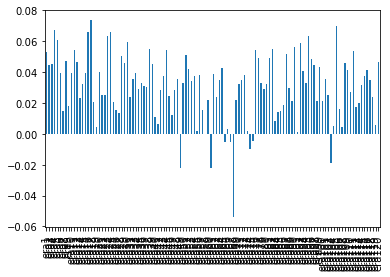

autocorrelation
0.22413687032929355
mean correlation
0.0304442249314046
sharpe
1.4229684633412196
numerai sharpe
3.2429614096390016
smart sharpe
3.9156340169691246
predicting on validation


<ipython-input-9-808f5e9cc369>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df["pred"] = preds_val


getting per val_era scores
performance over time


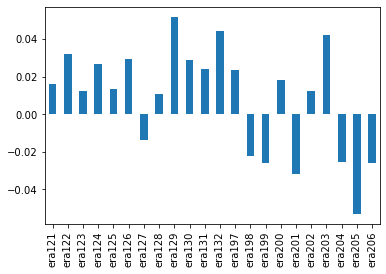

val_autocorrelation
0.32313724684481304
val_mean correlation
0.008542068981658399
val_sharpe
0.3062729660399387
val numerai sharpe
-0.23264498942283066
val_smart sharpe
0.7538545578216855
saving best scored model...
new max_score: 0.8445666724021104
101/101 [==============================] - 13s 130ms/step - loss: 0.1253 - mae: 0.3024 - mse: 0.1253 - val_loss: 0.1277 - val_mae: 0.3098 - val_mse: 0.1277
Epoch 2/5
 96/101 [===========================>..] - ETA: 0s - loss: 0.1248 - mae: 0.3016 - mse: 0.1248
predicting on train
getting per era scores
performance over time


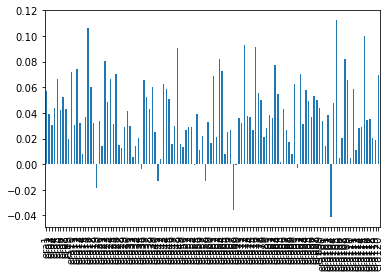

autocorrelation
0.017168081934198897
mean correlation
0.03686972938138073
sharpe
1.3252423598122016
numerai sharpe
3.2939482916205733
smart sharpe
4.49442579579888
predicting on validation


<ipython-input-9-808f5e9cc369>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df["pred"] = preds_val


getting per val_era scores
performance over time


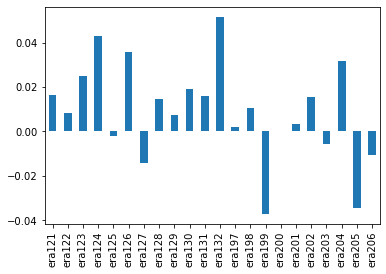

val_autocorrelation
-0.10605054662952197
val_mean correlation
0.008876975486370129
val_sharpe
0.4125437974980231
val numerai sharpe
-0.24762951379645215
val_smart sharpe
1.2614083365173125
saving best scored model...
new max_score: 1.4440765711916237
101/101 [==============================] - 13s 129ms/step - loss: 0.1247 - mae: 0.3016 - mse: 0.1247 - val_loss: 0.1262 - val_mae: 0.3068 - val_mse: 0.1262
Epoch 3/5
 97/101 [===========================>..] - ETA: 0s - loss: 0.1246 - mae: 0.3013 - mse: 0.1246
predicting on train
getting per era scores
performance over time


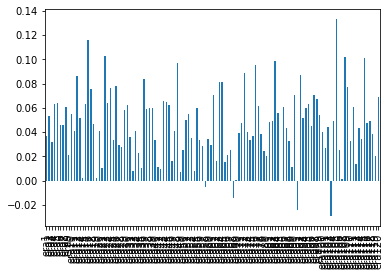

autocorrelation
-0.008428099991570272
mean correlation
0.045263365661980755
sharpe
1.5607435631928375
numerai sharpe
4.162515154362447
smart sharpe
5.339187540199831
predicting on validation


<ipython-input-9-808f5e9cc369>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df["pred"] = preds_val


getting per val_era scores
performance over time


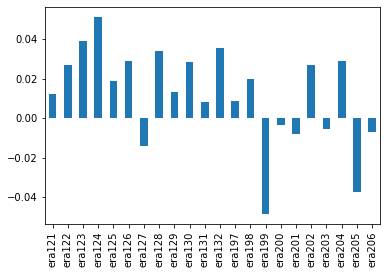

val_autocorrelation
0.05032969463128943
val_mean correlation
0.011610721468184886
val_sharpe
0.4809552063202858
val numerai sharpe
0.17155766861197322
val_smart sharpe
1.5513704808691116
saving best scored model...
new max_score: 2.2271047987377406
101/101 [==============================] - 13s 131ms/step - loss: 0.1246 - mae: 0.3013 - mse: 0.1246 - val_loss: 0.1258 - val_mae: 0.3057 - val_mse: 0.1258
Epoch 4/5
 95/101 [===========================>..] - ETA: 0s - loss: 0.1246 - mae: 0.3016 - mse: 0.1246
predicting on train
getting per era scores
performance over time


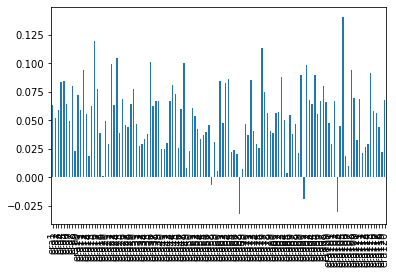

autocorrelation
0.04393111803848247
mean correlation
0.05162585275089753
sharpe
1.7211535565056877
numerai sharpe
4.759408496349417
smart sharpe
5.6840923718306575
predicting on validation


<ipython-input-9-808f5e9cc369>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df["pred"] = preds_val


getting per val_era scores
performance over time


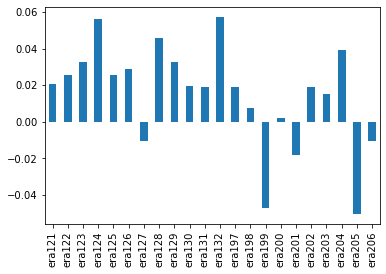

val_autocorrelation
0.1814995664571537
val_mean correlation
0.014917223710470068
val_sharpe
0.5377366671396137
val numerai sharpe
0.5621917740040493
val_smart sharpe
1.5278763074458281
saving best scored model...
new max_score: 2.657639196010431
101/101 [==============================] - 13s 132ms/step - loss: 0.1245 - mae: 0.3014 - mse: 0.1245 - val_loss: 0.1253 - val_mae: 0.3040 - val_mse: 0.1253
Epoch 5/5
 91/101 [==========================>...] - ETA: 0s - loss: 0.1246 - mae: 0.3017 - mse: 0.1246
predicting on train
getting per era scores
performance over time


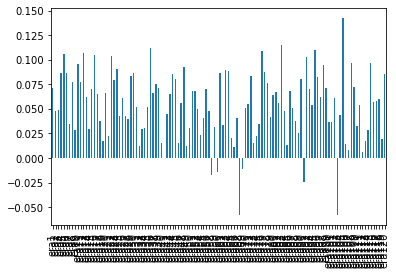

autocorrelation
0.10153610334955858
mean correlation
0.05358011529529667
sharpe
1.5328930918382535
numerai sharpe
4.277895801538547
smart sharpe
4.779780048348242
predicting on validation


<ipython-input-9-808f5e9cc369>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df["pred"] = preds_val


getting per val_era scores
performance over time


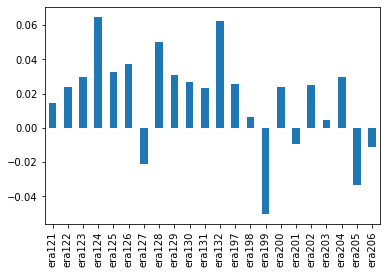

val_autocorrelation
0.07951305563663567
val_mean correlation
0.017575967999980114
val_sharpe
0.6278277072707599
val numerai sharpe
0.8860826666639091
val_smart sharpe
1.9692899997257856
saving best scored model...
new max_score: 3.518352309660415
101/101 [==============================] - 13s 128ms/step - loss: 0.1245 - mae: 0.3015 - mse: 0.1245 - val_loss: 0.1249 - val_mae: 0.3022 - val_mse: 0.1249


In [11]:
callbacks = [calculateScores(train_df, val_df, max_score_save_file)]

epochs=5
batch_size = len(train_df) // 100

model.fit(train_df[features], train_df['target_kazutsugi'], epochs=epochs, batch_size=batch_size, shuffle=True, validation_data=(val_df[features], val_df['target_kazutsugi']), callbacks=callbacks)     

### Load the best model and make predictions for tournament

Now that the model has been trained and the best model based on our metrics has been saved to disk we can now use it to make predictions for the tournament.

In [12]:
model = tf.keras.models.load_model(max_score_save_file)

In [13]:
tournament_df['predict'] = model.predict(tournament_df[features])

In [14]:
tournament_df[['id', 'predict']].head()

,id,predict
0,n0003aa52cab36c2,0.482140
1,n000920ed083903f,0.483947
2,n0038e640522c4a6,0.552625
3,n004ac94a87dc54b,0.484788
4,n0052fe97ea0c05f,0.491236


In [15]:
tournament_df[['id', 'predict']].to_csv(f'./{predictions_file_name}', index=False)